In [1]:
# Let us first load the MNIST dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Import modules
import tensorflow as tf
sess = tf.InteractiveSession()

# Create placeholders for the input images and the target classes
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Variables in our model (weights and biases)
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Initialize all tf variables
sess.run(tf.global_variables_initializer())

In [3]:
# This is our regression model
y = tf.matmul(x, W) + b

# Define a loss function (cross entropy)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))

In [4]:
# Train the model using gradient descent with a step size of 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# Run training step multiple times to reduce loss
for i in range(int(1e3)):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_:batch[1]})

In [5]:
# Evaluate the model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# Get percentage of correct results (accuracy)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Print accuracy on test images
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9146


In [6]:
# Create new weights and biases. Since we are going to have a lot of these,
# it is nice to define functions to create them for us.

def weight_variable(shape):
    """Create a weight matrix with shape=shape and slight noise to prevent a zero gradient"""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias vector with shape=shape and a slight offset to prevent dead neurons."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution will be done with a stride of 1 zero-padding to produce a filtered image
# of the same size as the input image. Again, we use functions for this to keep our
# code clean.

def conv2d(x, W):
    """Do a convolution of x with filter W. The stride is 1 and we have 'SAME' padding."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# We use 2x2 pooling to reduce the size of the filtered image.

def max_pool_2x2(x):
    """Max pooling done to x with a 2x2 sweep"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [7]:
# First convolutional layer (Convolution + Pooling) with 32 filters
# of size 5x5 and 32 biases

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# Reshape input image
x_image = tf.reshape(x, [-1, 28, 28, 1])

# Apply con2d, add bias, nonlinearly transform with RELU
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second convolutional layer: 64 filters for each 5x5 patch
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [8]:
# Fully connected layer with 1024 Neurons

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [9]:
# Neuron Dropout to reduce overfitting

# Probability of a neuron staying connected
keep_prob = tf.placeholder(tf.float32)
# Use tensorflows in-built dropout function to mask neurons
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [10]:
# Readout Layer

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [11]:
# Train and Evaluate The Model

# Loss function (cross entropy)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

# Training step using ADAM optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Mask of correct predictions
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

# Calculate accuracy percentage
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Run session
sess.run(tf.global_variables_initializer())

# Train over many steps
for i in range(100):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# Print accuracy
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
test accuracy 0.84


In [12]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


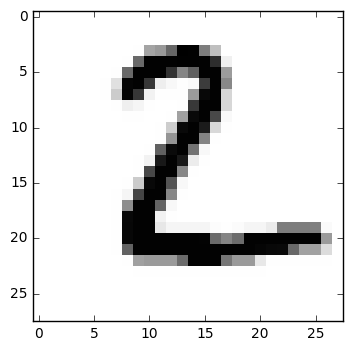

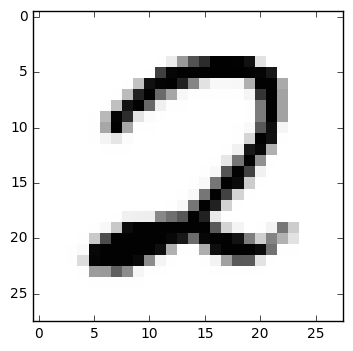

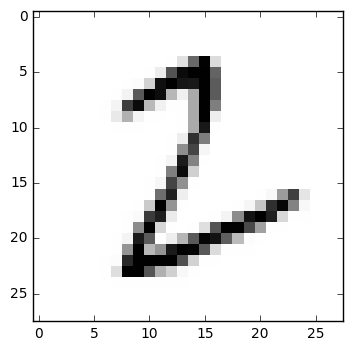

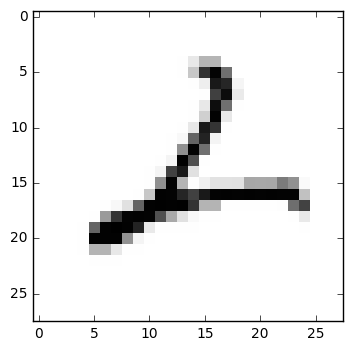

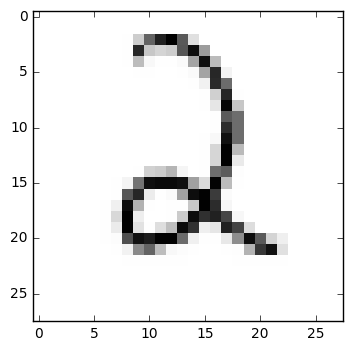

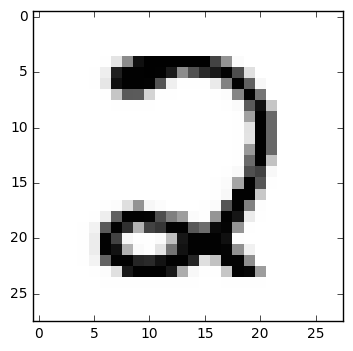

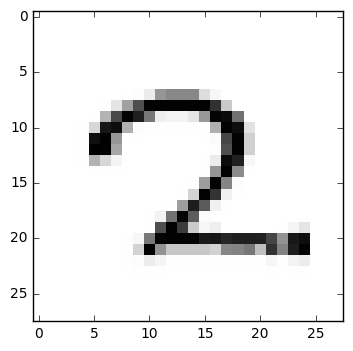

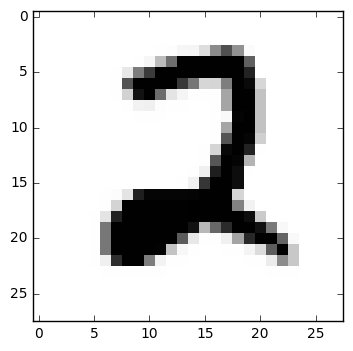

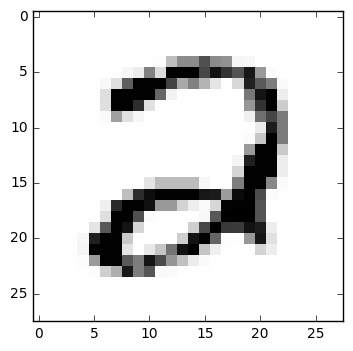

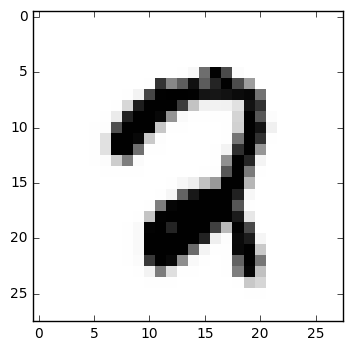

In [13]:
# The indicies of the first 10 "2" images
two_idxs = np.where(mnist.test.labels[:, 2].astype(int) == 1)[0][:10]

# Select 10 of these images using the mask
two_images = mnist.test.images[two_idxs]

# Print the images (to be sure, you know?)
for i in range(len(two_images)):
    plt.figure()
    plt.imshow(two_images[i].reshape((28, 28)), interpolation='None', cmap='Greys')

In [14]:
# Test the trained network on the sample images
network_estimate = tf.argmax(y_conv,1).eval(feed_dict={
        x: mnist.test.images[two_idxs], y_: mnist.test.labels[two_idxs], keep_prob: 1.0})

print(network_estimate)

[2 2 2 2 2 2 7 2 2 2]
